## **NOISY TIME-SERIES PSEUDO-PERIODIC DATA CLEANING**

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tslearn.clustering import TimeSeriesKMeans
import pywt
from scipy.signal import find_peaks
from IPython.display import display

import warnings
warnings.filterwarnings("ignore")

## Problem Statement

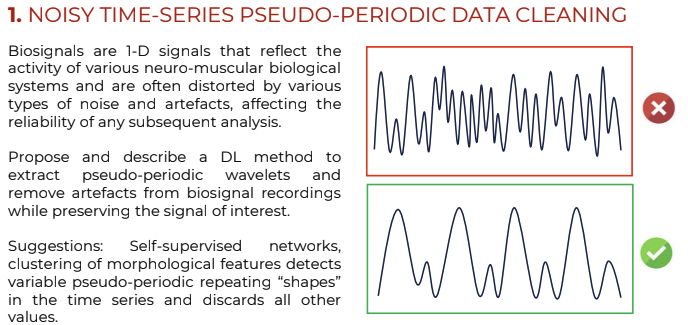

## **Exploratory Data Analysis**

- We use noisy pseudo-periodic dataset from [Kaggle](https://www.kaggle.com/datasets/vipulgote4/pseudo-periodic-synthetic-time-series)
- We want to know:
  - Data features
  - Simple visualization
  - Data Cleanliness


In [6]:
df = pd.read_excel('data/data.xlsx', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000552,0.000387,0.000495,0.000564,0.000444,0.000485,0.000475,0.000490,0.000503,0.000430
2,0.001103,0.000775,0.000990,0.001127,0.000888,0.000971,0.000950,0.000980,0.001006,0.000859
3,0.001655,0.001162,0.001484,0.001690,0.001333,0.001456,0.001425,0.001470,0.001509,0.001288
4,0.002207,0.001549,0.001979,0.002254,0.001777,0.001942,0.001901,0.001959,0.002012,0.001718


In [7]:
df_sample = df.iloc[1:].sample(n=999, random_state=42)
df_sample = pd.concat([pd.DataFrame(df.iloc[0,:]).T, df_sample], axis=0)
df_sample.sort_index(inplace=True)

# make the index becomes time column
df_sample["x"] = df_sample.index

# reset index
df_sample.reset_index(drop=True, inplace=True)

df_sample.head()

,0,1,2,3,4,5,6,7,8,9,x
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
1,0.044965,0.033299,0.041785,0.045621,0.037335,0.041636,0.040481,0.039656,0.042155,0.035967,88
2,0.055851,0.042819,0.053059,0.056470,0.047276,0.053441,0.051714,0.049074,0.053234,0.045457,115
3,0.067314,0.054380,0.065980,0.067827,0.058577,0.067651,0.064943,0.058902,0.065588,0.056219,150
4,0.084197,0.076088,0.086669,0.085400,0.076779,0.093606,0.087668,0.073993,0.083794,0.074035,227


In [8]:
display("Missing data for each section")
display(df_sample.isnull().sum())

'Missing data for each section'

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
x    0
dtype: int64

> This data set is designed for testing indexing schemes in time series databases. It is a much larger dataset than has been used in any published study (That we are currently aware of). It contains **one million data points**. The data has been split into **10 sections** to facilitate testing (see below). We recommend building the index with 9 of the 100,000-datapoint sections, and randomly extracting a query shape from the 10th section. (Some previously published work seems to have used queries that were also used to build the indexing structure. This will produce optimistic results) The data are interesting because they have structure at different resolutions.

Hence, we can assume the data has **uniform** indices, because it is being equally splitted into 10 sections, each is comprised of 100.000 instances

### Let's **visualize each section** to see what the data is comprised of.

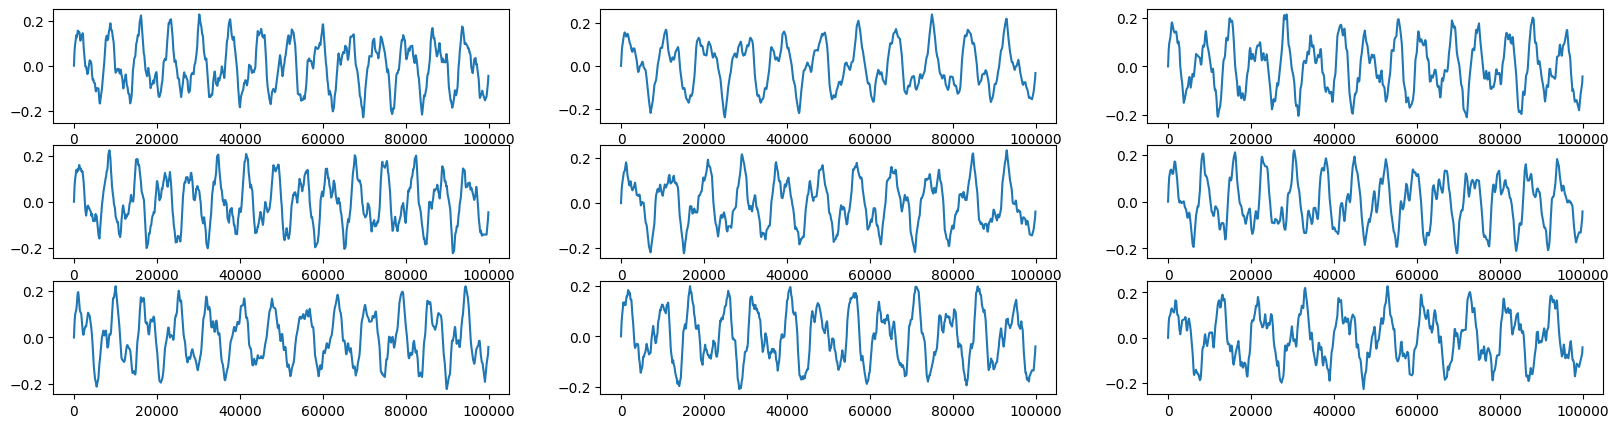

In [9]:
# for every section 0 - 9 , visualize the data into 1 figure with 3 axes each row
fig, axes = plt.subplots(3, 3, figsize=(20, 5))
for i in range(3):
    for j in range(3):
        axes[i,j].plot(df_sample["x"], df_sample[i*3+j])
plt.show()

## Uniform Wave Extraction (**8 waves**)

The signal is comprised of different frequencies, hence producing different count of cycles, let's take first **8 cycle** from each data

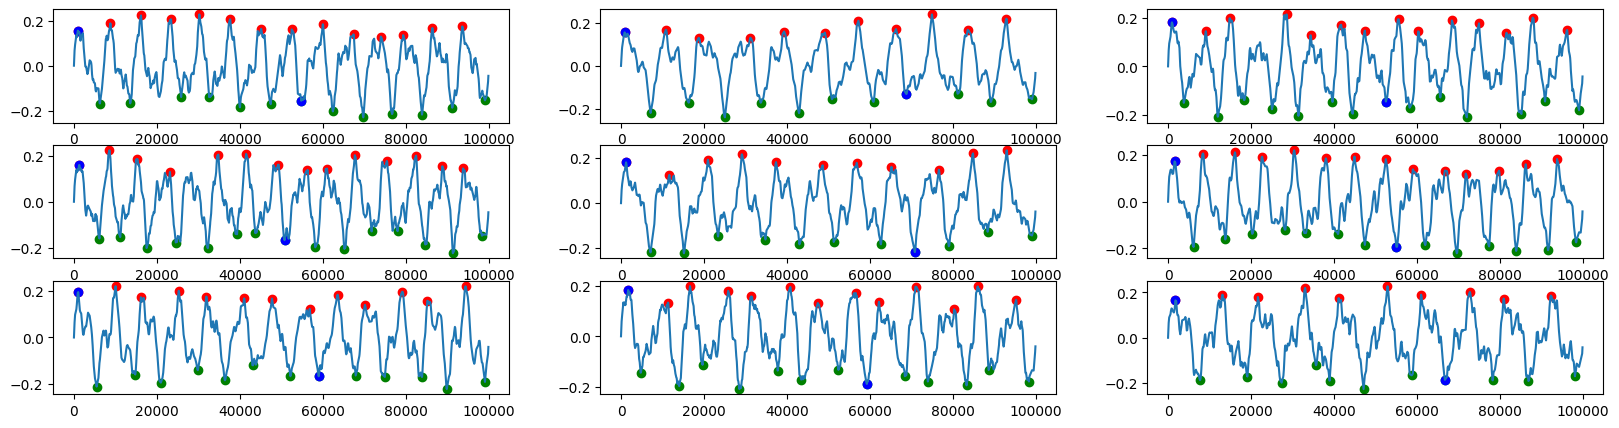

In [10]:
fig, axes = plt.subplots(3, 3, figsize=(20, 5))

start_end = []

for i in range(3):
    for j in range(3):
        peaks_idx,_ = find_peaks(df_sample.iloc[:,i*3 + j], height = 0.1, distance=40)
        valleys_idx, _ = find_peaks(-df_sample.iloc[:,i*3 + j], height = 0.1, distance=40)

        axes[i,j].plot(df_sample["x"], df_sample.iloc[:,i*3 + j])
        axes[i,j].scatter(df_sample["x"].iloc[peaks_idx], df_sample.iloc[:,i*3 + j].iloc[peaks_idx], color='red')
        axes[i,j].scatter(df_sample["x"].iloc[valleys_idx], df_sample.iloc[:,i*3 + j].iloc[valleys_idx], color='green')

        # get first 8 peaks and valleys
        peak_8 = df_sample.iloc[peaks_idx[:8]].index.values
        valley_8 = df_sample.iloc[valleys_idx[:8]].index.values

        idx = []
        i_p, i_v = 0, 0
        while i_p < 8 and i_v < 8:
            if peak_8[i_p] < valley_8[i_v]:
                i_p += 1
            else:
                i_v += 1
            
        start_i = peak_8[0]
        end_i = valley_8[i_v if i_v < 8 else i_v - 1]
        axes[i,j].scatter(df_sample["x"].iloc[start_i], df_sample.iloc[:,i*3 + j].iloc[start_i], color='blue')
        axes[i,j].scatter(df_sample["x"].iloc[end_i], df_sample.iloc[:,i*3 + j].iloc[end_i], color='blue')

        start_end.append((start_i, end_i))
    
plt.show()

Here we are grouping top **8 peaks** and valleys to triangulate only the first **8 waves**, so the comparison will be apple to apple for pattern extraction

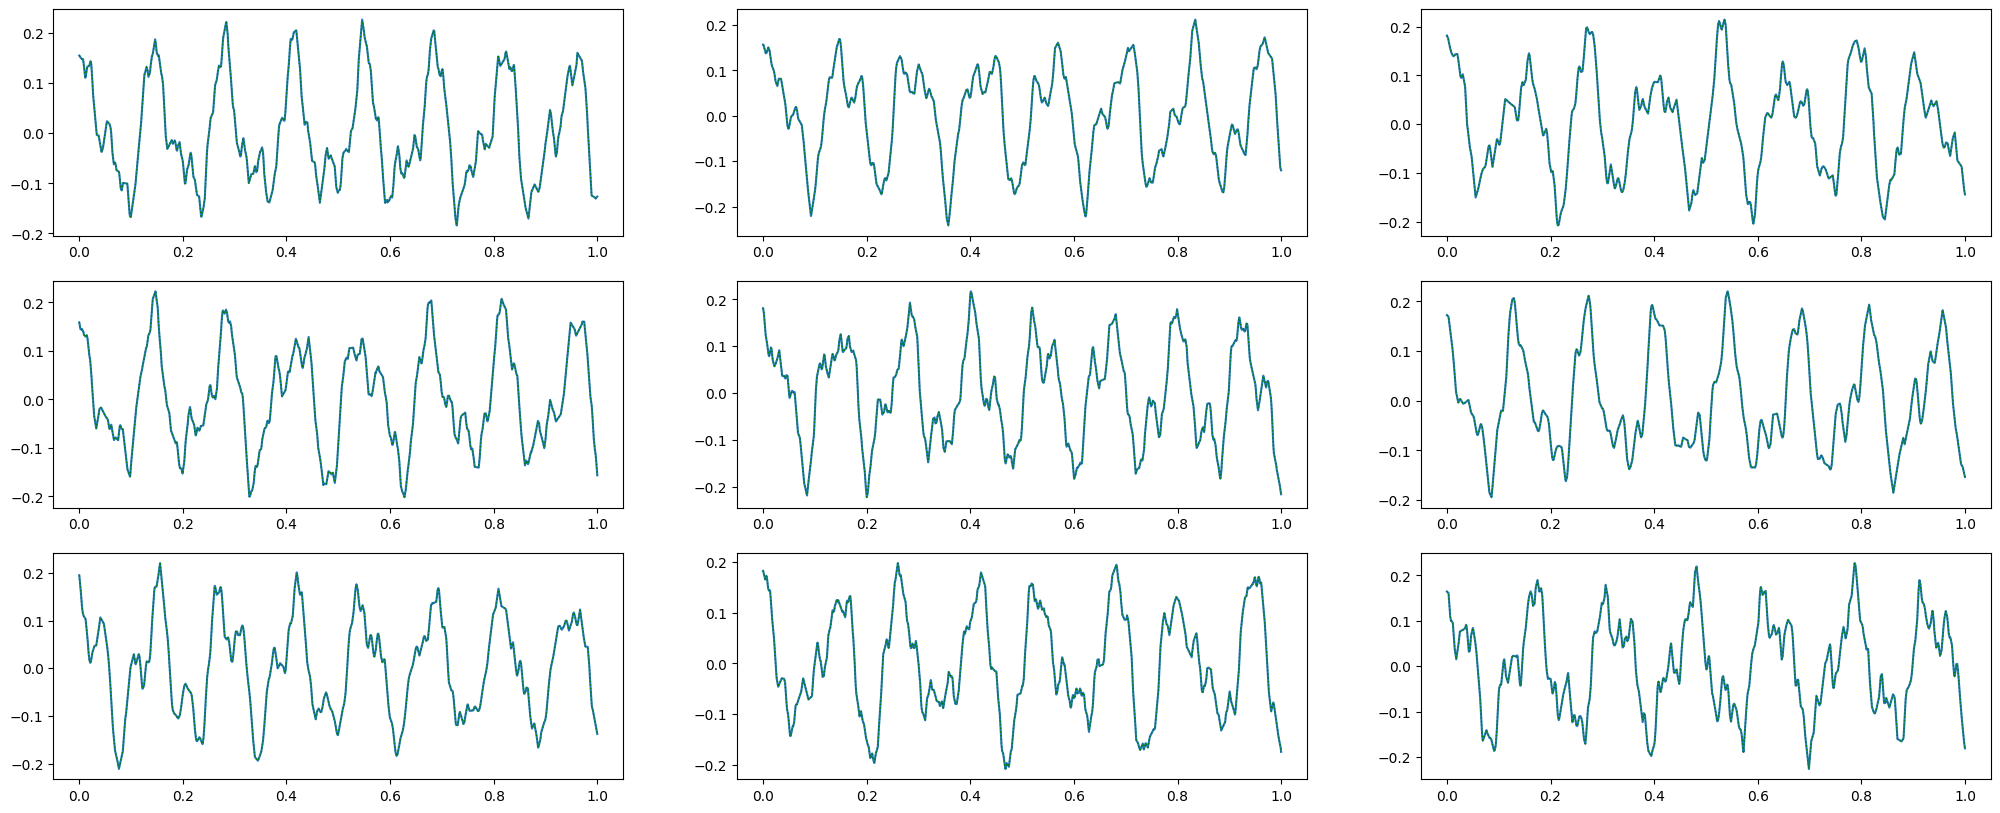

In [12]:
preprocessed_df = pd.DataFrame()

fig, axes = plt.subplots(3, 3, figsize=(25, 10))
for i in range(3):
    for j in range(3):
        # before plotting, normalize the x become 0 - 1
        x = df_sample["x"].iloc[start_end[i*3+j][0]:start_end[i*3+j][1]]
        x = (x - x.min()) / (x.max() - x.min())
        axes[i,j].plot(x, df_sample.iloc[start_end[i*3+j][0]:start_end[i*3+j][1], i*3+j])

        # and then, make the amount of data become 1000
        x_new = np.linspace(0, 1, 1000)
        y = df_sample.iloc[start_end[i*3+j][0]:start_end[i*3+j][1], i*3+j]
        y_new = np.interp(x_new, x, y)

        axes[i,j].plot(x_new, y_new, color = "green", linestyle='dotted', linewidth=1)

        # add to preprocessed_df x_new, y_new
        if "x" not in preprocessed_df.columns:
            preprocessed_df["x"] = x_new
        preprocessed_df[i*3+j] = y_new

preprocessed_df.set_index("x", inplace=True)
plt.show()

From this point, we will be using these waves to extract common patterns that underlies among them.

So, we have 9 sections which all of them is generated from random sinusoidal function. Let's assume this is a medical scanning data and we want to extract a clean, well-agreed pattern to be evaluated within the test data.

### **Split Dataset**

In [13]:
train_data = preprocessed_df.iloc[:,:7]
test_data = preprocessed_df.iloc[:,7:8]

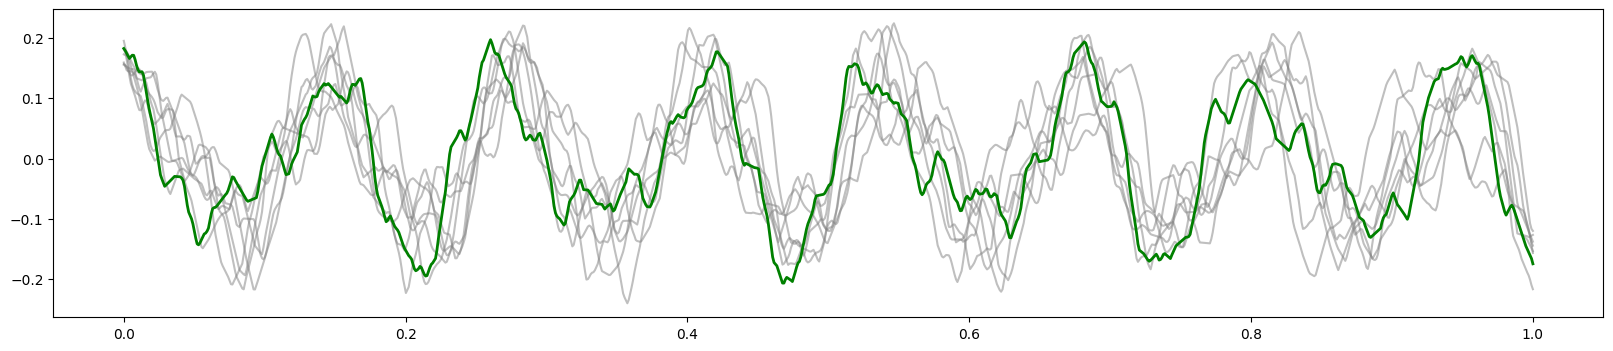

In [14]:
plt.figure(figsize=(20, 4))
for i in range(7):
    plt.plot(train_data.index, train_data.iloc[:,i], color='gray', alpha=0.5)
plt.plot(test_data.index, test_data.iloc[:,0], color='green', linewidth=2) 

plt.show()

We can observe the training data while being compared with **test data**, primarily caused by:
- Different peak count between samples
- Different oscillatory distribution
- Different amplitudes and frequencies

### **Clustering**

In [40]:
def TSCluster(data, cluster_count):
    x = [pd.DataFrame(data.iloc[:, i]) for i in range(7)]
    km = TimeSeriesKMeans(n_clusters=cluster_count, metric="dtw", random_state=43)

    y = km.fit_predict(x)

    return x, y

def plot_cluster(x, y, cluster_count):
    if cluster_count > 1:
        fig, axs = plt.subplots(cluster_count, 1, figsize=(20, 5))
    elif cluster_count == 1:
        fig, axs = plt.subplots(1, 1, figsize=(20, 5))
        axs = [axs]

    fig.suptitle(f'Cluster {cluster_count}')
    clust_dfs = []
    i_plot = 0
    for label in set(y):
        cluster = []
        for i in range(len(y)):
                if(y[i]==label):
                    axs[i_plot].plot(x[i],c="gray",alpha=0.4)
                    cluster.append(x[i])
        if len(cluster) > 0:
            avg = pd.DataFrame(np.average(cluster, axis=0).flatten(), index=cluster[0].index)
            axs[i_plot].plot(avg, c="red", linewidth = 0.5)
            clust_dfs.append(avg)
        
        i_plot += 1
    
    return clust_dfs

### **K-Means**

Let's evaluate which cluster count suits the most

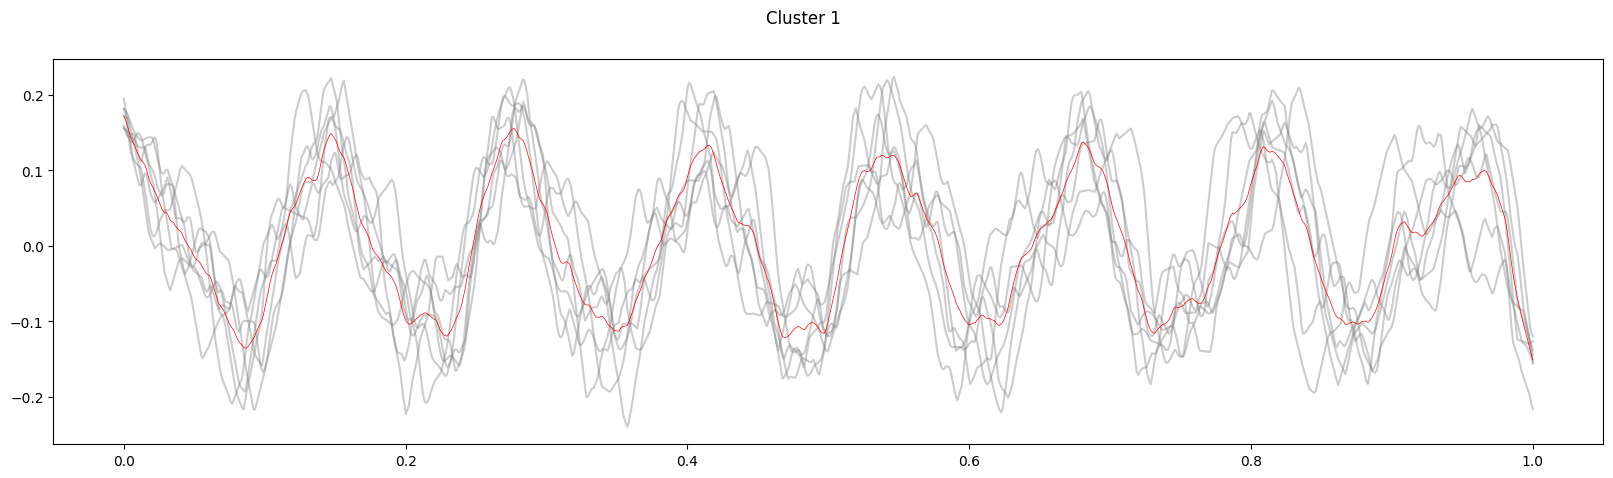

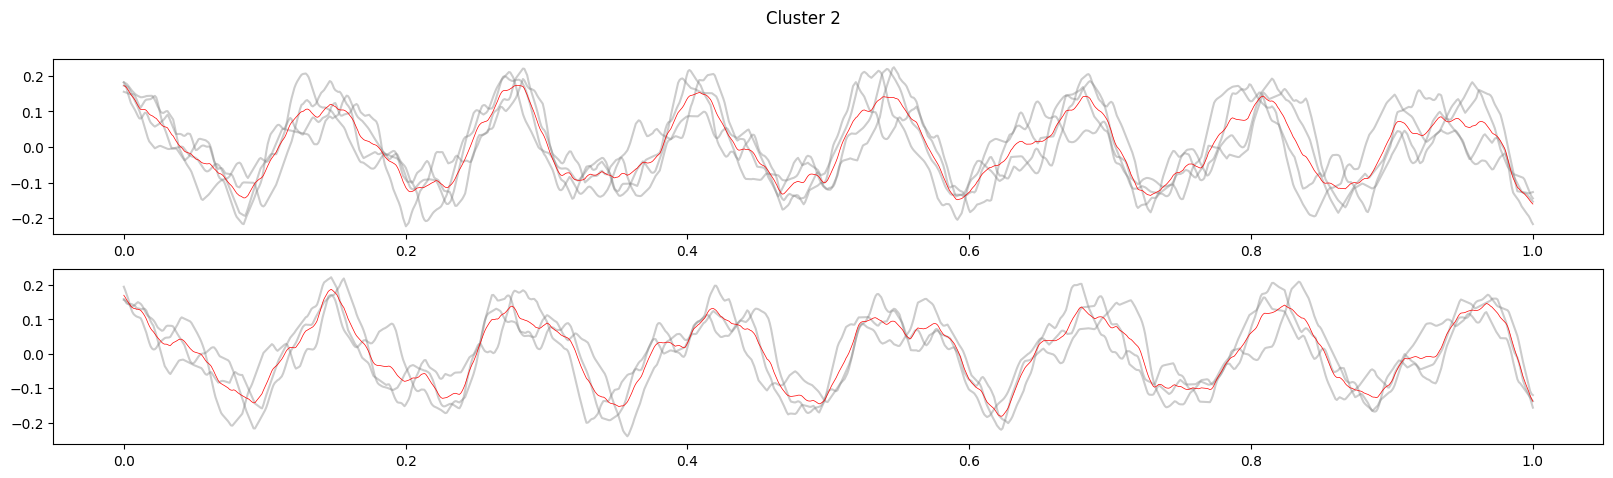

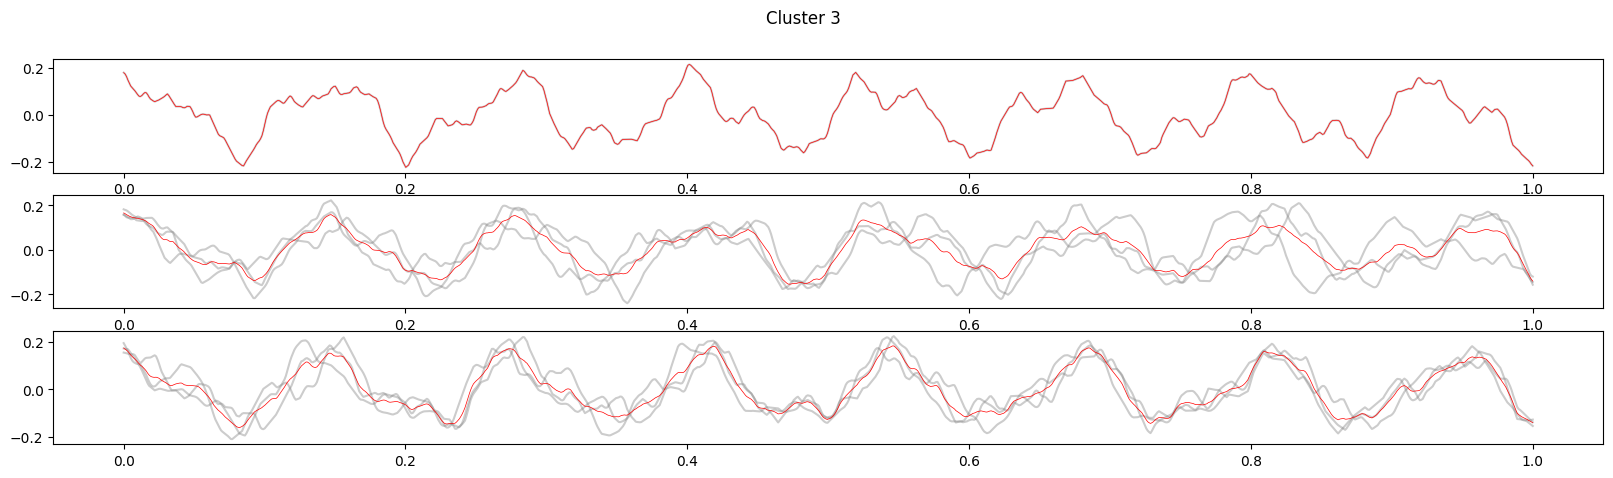

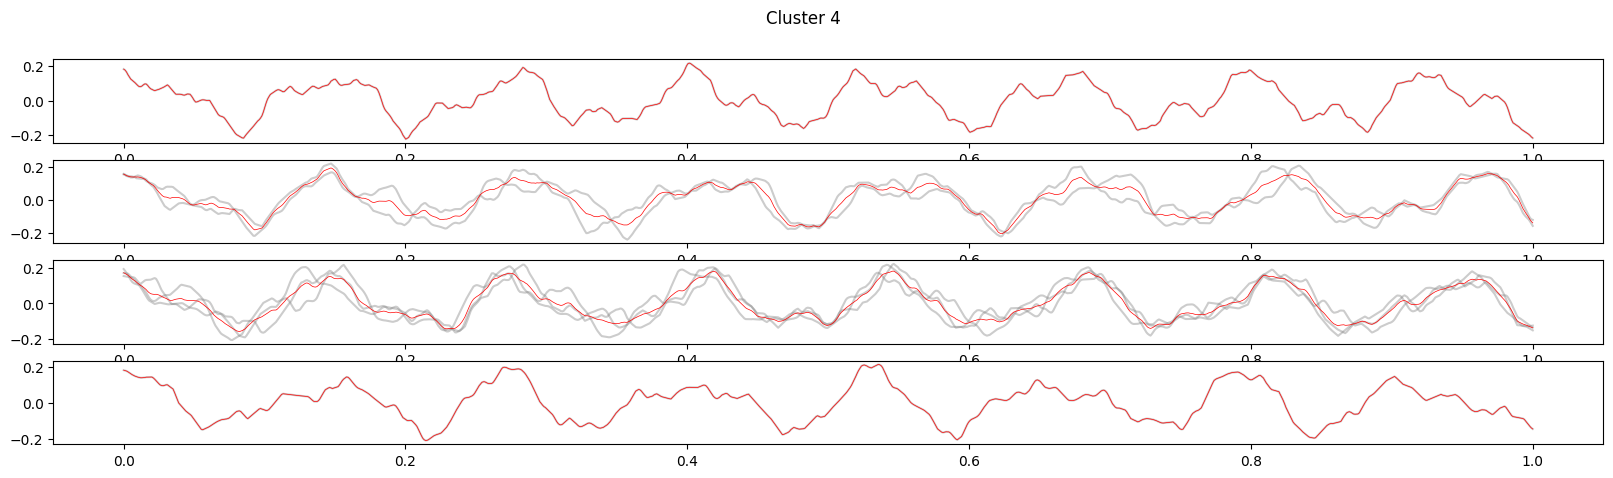

In [43]:
for i in range(1,5):
    x, y = TSCluster(train_data, i)
    _ = plot_cluster(x, y, i)

### **Cluster Analysis**
- We can observe here that cluster count beyond 3 produces inaccurate result where there are one or more cluster with only 1 pattern. Hence indicating overfitting. 
- The ultimate **critical point** is at cluster 2 where we will conduct further **smoothing** to remove (slight) white noises

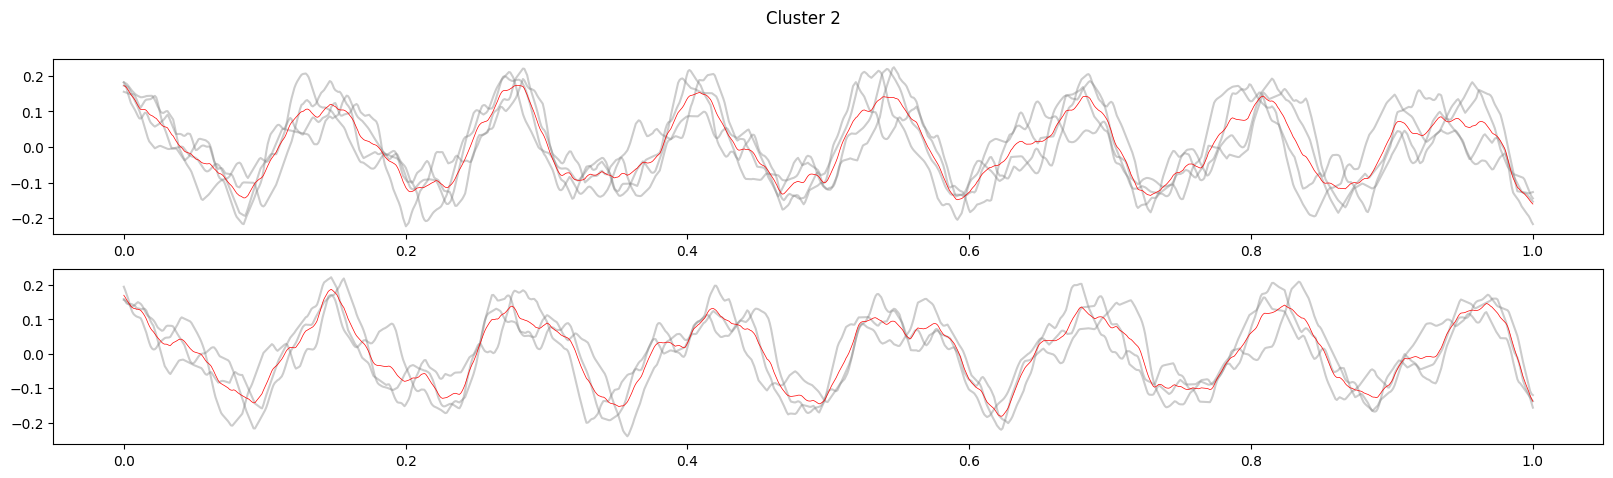

In [41]:
x, y = TSCluster(train_data, 2)
clust_dfs = plot_cluster(x, y, 2)

### Determine Which cluster has less **MSE** (both `test` and `train` data)
Since we may only choose only 1 cluster, let's judge which cluster that has more concensus agreement among the training data by using simple residual metric

In [42]:
from sklearn.metrics import mean_squared_error

for i in range(2):
    total_mse =0.0
    for data in x:
        total_mse += mean_squared_error(data, clust_dfs[i])
    
    print(f"Cluster {i+1} MSE (test): {mean_squared_error(test_data, clust_dfs[i])}")
    print(f"Cluster {i+1} MSE (train): {total_mse}")
    print()

Cluster 1 MSE (test): 0.0035412096488179117
Cluster 1 MSE (train): 0.02738847429401246

Cluster 2 MSE (test): 0.005558175783730004
Cluster 2 MSE (train): 0.031158258062536675



### Proceed with `cluster[0]`
Slight difference, but **Cluster 1** will be the option as it satisfies better result in MSE difference in both `train` & `test` datas

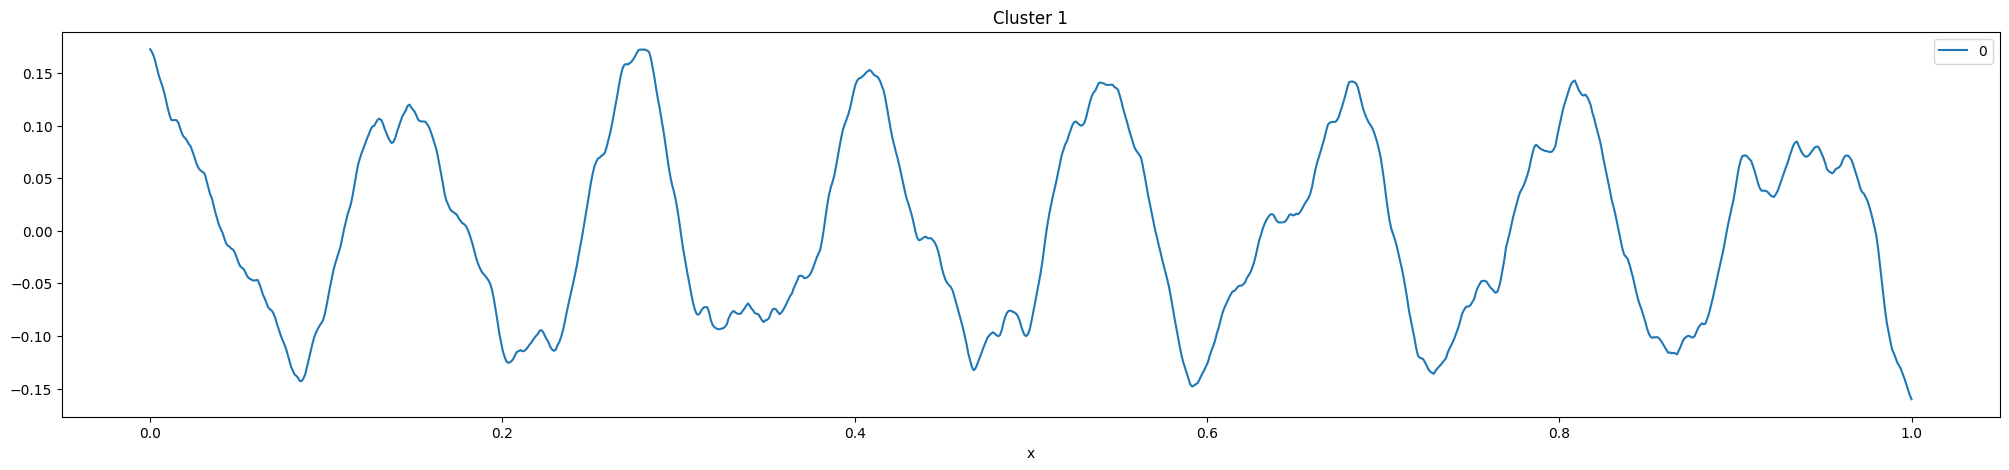

In [44]:
final_df = clust_dfs[0]
fig = plt.figure(figsize=(25, 5))
sns.lineplot(data = final_df)
plt.title("Cluster 1")
plt.show()

### Smoothing Data to reduce features using `pywt`
We will reduce the noise by detaching the unused `coeff` that is present in current "raw" extracted wave

In [49]:
import pywt

val = final_df.values.flatten()

# make series which value is y.values, and index enumerated from 0 to len(y)
series = pd.Series(val, index=range(len(val)))
series

0      0.172680
1      0.170018
2      0.166165
3      0.160419
4      0.153739
         ...   
995   -0.140636
996   -0.145851
997   -0.150958
998   -0.156152
999   -0.160176
Length: 1000, dtype: float64

### **Noise** Mapping

For each order of coefficient underlies in wavelet creation, let's assess how noisy and determine the detail cutoff to reduce overdetail.

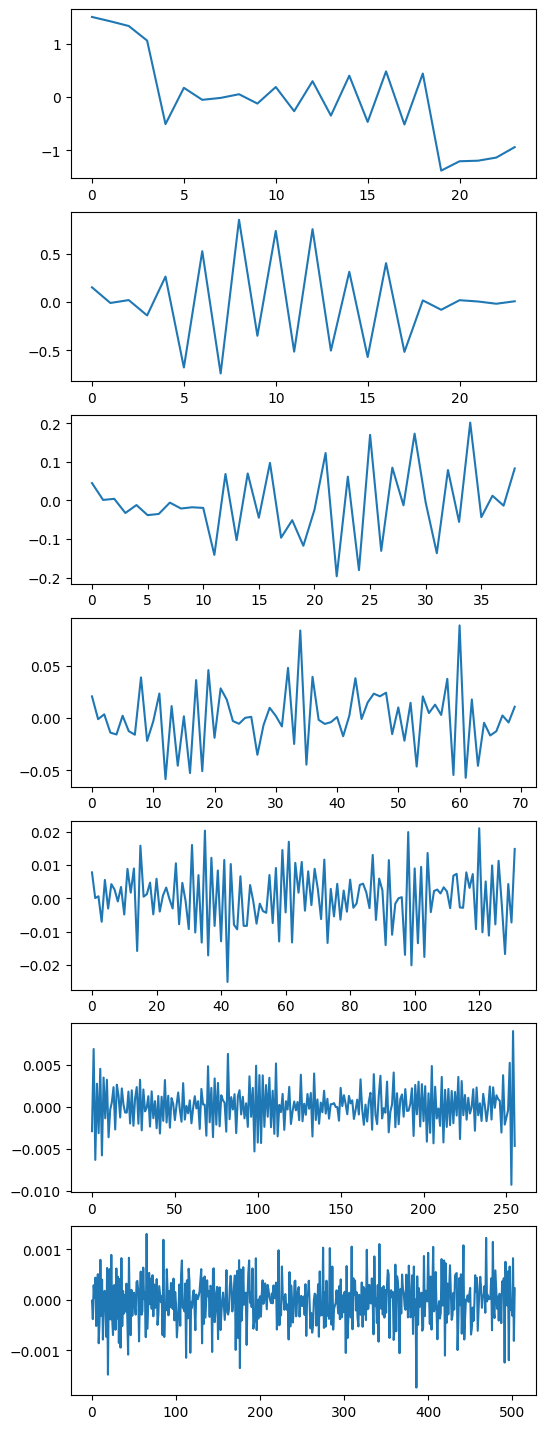

In [50]:
# perform wavelet decomposition
coeffs = pywt.wavedec(series, 'sym5', mode='symmetric')

# plot wavelet decompositions

plt.figure(figsize=(6,18))

for i in range(len(coeffs)):
    plt.subplot(len(coeffs),1, i+1)
    plt.plot(coeffs[i])

### We will remove **top-4** noisy `coeff` from the equation to reduce detail level

In [64]:
# zero out last 9 detail coefficents
for i in range(len(coeffs)-1, len(coeffs) - 1 - 4, -1):
    coeffs[i] = np.zeros_like(coeffs[i])

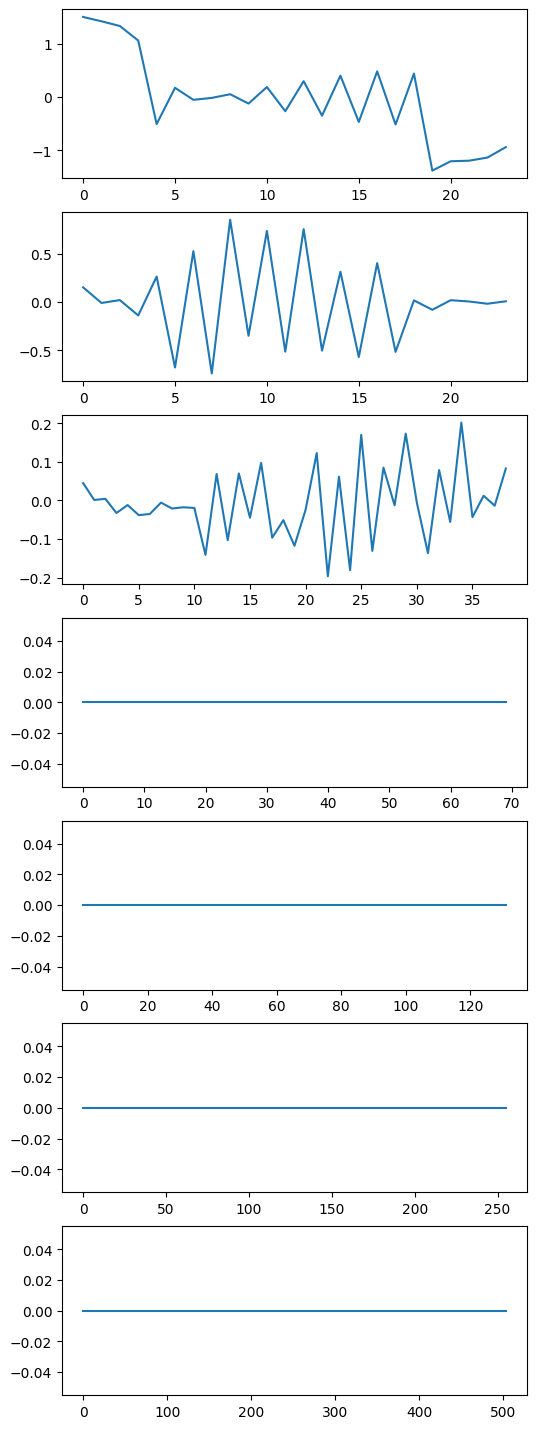

In [65]:
plt.figure(figsize=(6,18))

for i in range(len(coeffs)):
    plt.subplot(len(coeffs),1, i+1)
    plt.plot(coeffs[i])

In [66]:
x_ori = final_df.index
y_ori = final_df.values
y_smooth = pywt.waverec(coeffs, 'sym5', mode='symmetric')

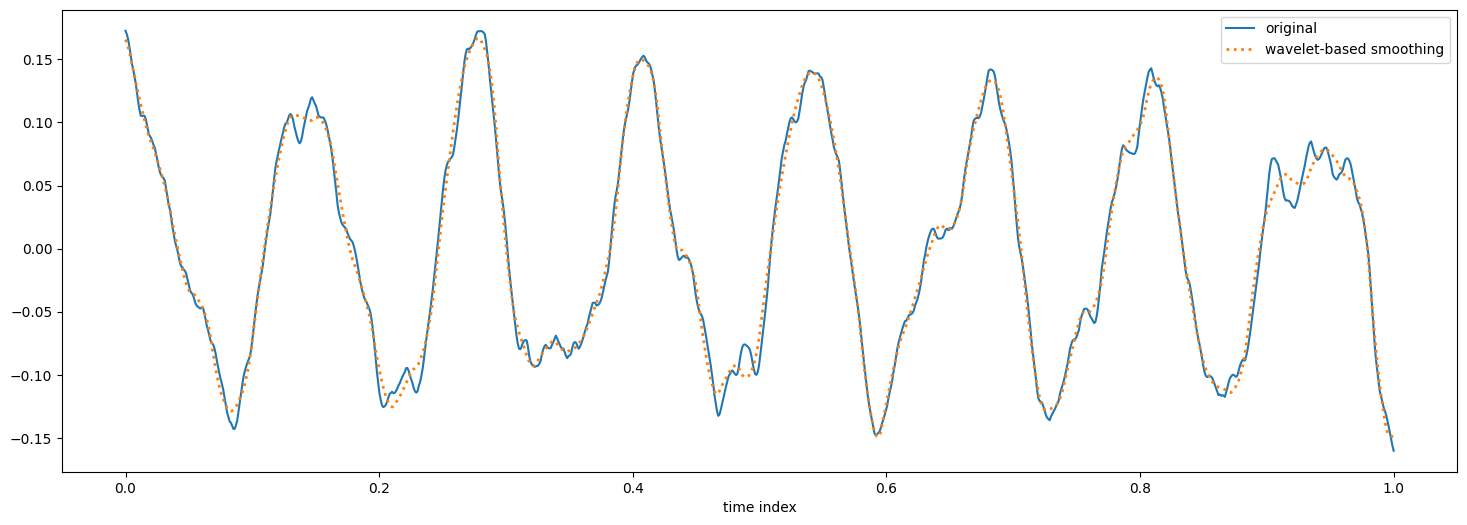

In [67]:
plt.figure(figsize=(18,6))
plt.plot(x_ori, y_ori)
plt.plot(x_ori, y_smooth, linestyle='dotted', linewidth=2)
plt.legend(['original', 'wavelet-based smoothing'])
plt.xlabel('time index')
plt.show()

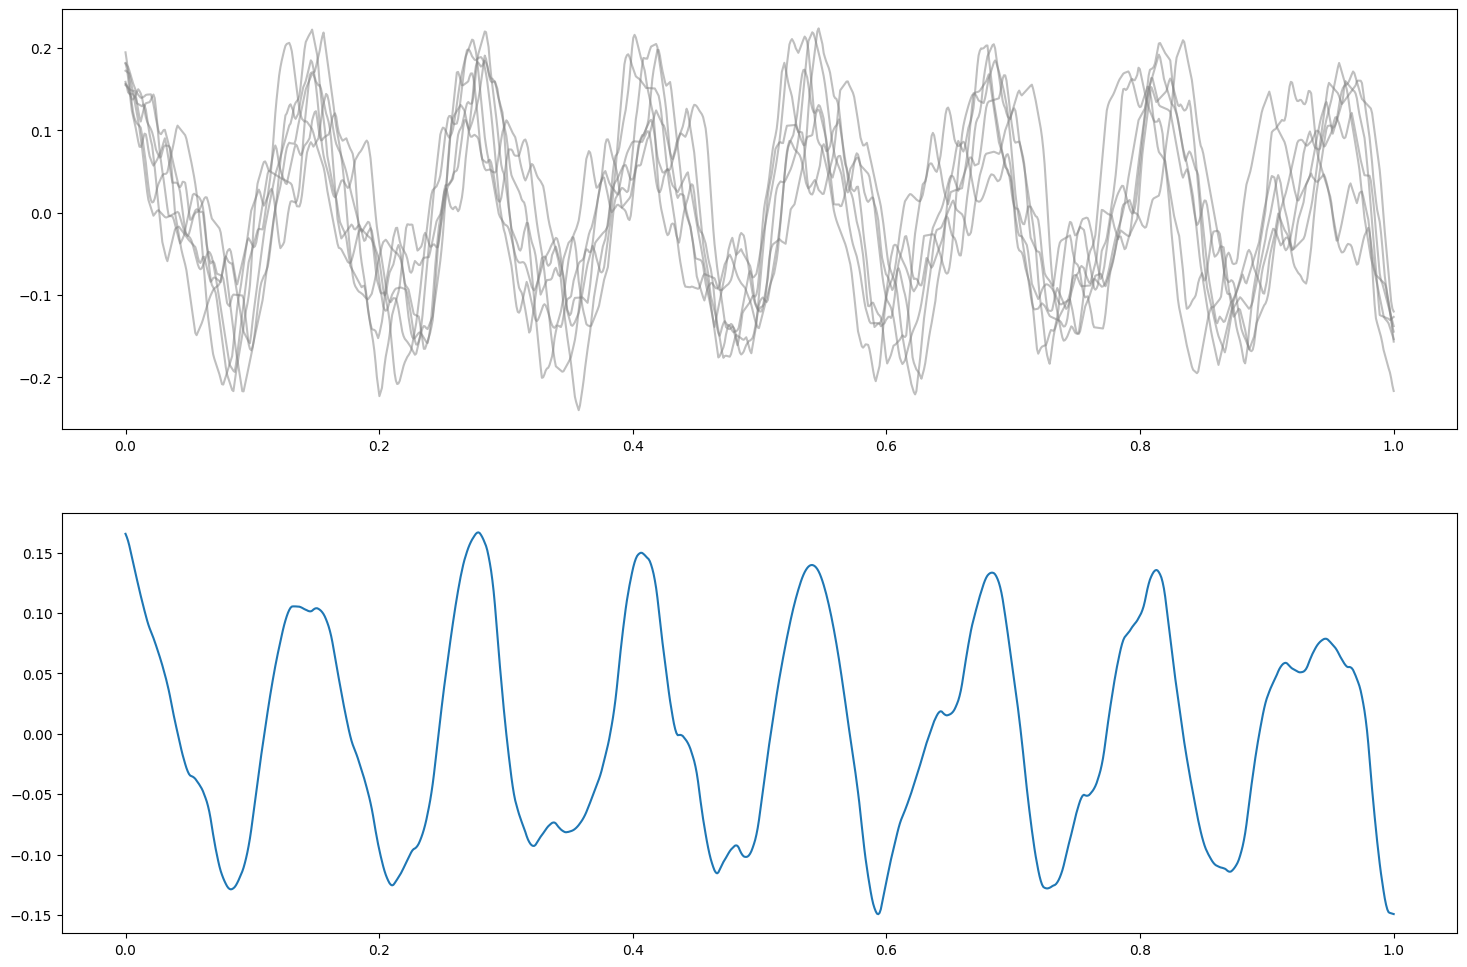

In [68]:
fig,ax = plt.subplots(2,1, figsize=(18,12))

# for ax[0] plot all of preprocessed data from 0-7 column with x  = x * 100000
for i in range(7):
    ax[0].plot(x_ori, preprocessed_df.iloc[:,i], alpha=0.5, color = "gray")

ax[1].plot(x_ori,y_smooth)
plt.show()

## **Voila!** we managed to capture mutual pattern from noisy data!